In [1]:
from SimPEG import *
import simpegDCIP as DC
%pylab inline
from pymatsolver import MumpsSolver

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [2]:
cs = 12.5
nc = 500/cs+1
hx = [(cs,7, -1.3),(cs,nc),(cs,7, 1.3)]
hy = [(cs,7, -1.3),(cs,int(nc/2+1)),(cs,7, 1.3)]
hz = [(cs,7, -1.3),(cs,int(nc/2+1))]

In [3]:
mesh = Mesh.TensorMesh([hx, hy, hz], 'CCN')
print mesh

  ---- 3-D TensorMesh ----  
   x0: -541.97
   y0: -416.97
   z0: -548.22
  nCx: 55
  nCy: 35
  nCz: 28
   hx: 78.44, 60.34, 46.41, 35.70, 27.46, 21.13, 16.25, 41*12.50, 16.25, 21.13, 27.46, 35.70, 46.41, 60.34, 78.44
   hy: 78.44, 60.34, 46.41, 35.70, 27.46, 21.13, 16.25, 21*12.50, 16.25, 21.13, 27.46, 35.70, 46.41, 60.34, 78.44
   hz: 78.44, 60.34, 46.41, 35.70, 27.46, 21.13, 16.25, 21*12.50


In [4]:
sighalf = 1e-2
sigma = np.ones(mesh.nC)*sighalf
p0 = np.r_[-50., 50., -50.]
p1 = np.r_[ 50.,-50., -150.]
blk_ind = Utils.ModelBuilder.getIndicesBlock(p0, p1, mesh.gridCC)
sigma[blk_ind] = 1e-3

In [6]:
eta = np.zeros_like(sigma)
eta[blk_ind] = 0.1

In [7]:
sigmaInf = sigma.copy()
sigma0 = sigma*(1-eta)

(-600.0, 600.0, -600.0, 0.0)

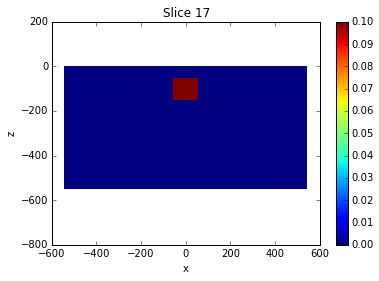

In [8]:
dat = mesh.plotSlice(eta, normal='Y')
plt.colorbar(dat[0])
axis('equal')

In [9]:
nElecs = 21
x_temp = np.linspace(-250, 250, nElecs)
aSpacing = x_temp[1]-x_temp[0]
y_temp = 0.
xyz = Utils.ndgrid(x_temp, np.r_[y_temp], np.r_[0.])

In [10]:
srcList = DC.Examples.WennerArray.getSrcList(nElecs,aSpacing)
survey = DC.SurveyDC(srcList)
print len(survey.srcList)

63


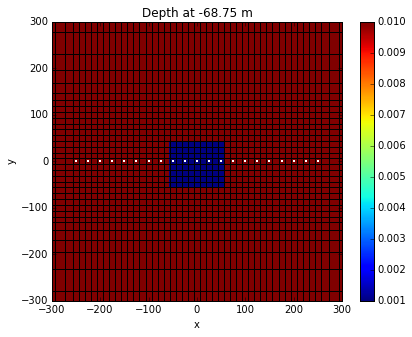

In [11]:
fig, ax = plt.subplots(1,1, figsize = (6.5,5))
indz = 22
dat = mesh.plotSlice(sigma, grid=True, ax = ax, ind=indz)
ax.set_xlim(-300, 300)
ax.set_ylim(-300, 300)
cb = plt.colorbar(dat[0])
ax.set_title('Depth at '+str(mesh.vectorCCz[indz])+' m')

txLocs = np.array([[tx.loc[0][0], tx.loc[1][0]] for tx in survey.srcList]).flatten()
ax.plot(txLocs, txLocs*0, 'w.', ms = 3)

In [12]:
expmap = Maps.ExpMap(mesh)
m2to3  = Maps.Map2Dto3D(mesh,normal='Y')
imap   = Maps.IdentityMap(mesh)
problem = DC.ProblemDC_CC(mesh, mapping= imap )
problem.Solver = MumpsSolver
try:
    problem.pair(survey)
except Exception, e:
    survey.unpair()
    problem.pair(survey)

In [18]:
%%time
phi0 = survey.dpred(sigma0)

CPU times: user 6.49 s, sys: 705 ms, total: 7.2 s
Wall time: 4.94 s


In [21]:
print mesh

  ---- 3-D TensorMesh ----  
   x0: -541.97
   y0: -416.97
   z0: -548.22
  nCx: 55
  nCy: 35
  nCz: 28
   hx: 78.44, 60.34, 46.41, 35.70, 27.46, 21.13, 16.25, 41*12.50, 16.25, 21.13, 27.46, 35.70, 46.41, 60.34, 78.44
   hy: 78.44, 60.34, 46.41, 35.70, 27.46, 21.13, 16.25, 21*12.50, 16.25, 21.13, 27.46, 35.70, 46.41, 60.34, 78.44
   hz: 78.44, 60.34, 46.41, 35.70, 27.46, 21.13, 16.25, 21*12.50


In [22]:
phiInf = survey.dpred(sigmaInf)

In [23]:
phiIP_true = phi0-phiInf

In [24]:
# F = problem.fields(mesh, survey)

In [25]:
surveyIP = DC.SurveyIP(srcList)
problemIP = DC.ProblemIP(mesh, sigma=sigma)
problemIP.pair(surveyIP)
problemIP.Solver = MumpsSolver

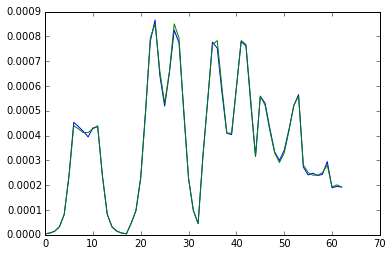

In [26]:
datasyn = surveyIP.dpred(eta)
surveyIP.makeSyntheticData(eta,std=0.02,force=True)
plot(np.c_[surveyIP.dobs,datasyn])

In [27]:
problemIP.mapping = imap

In [28]:
dmis = DataMisfit.l2_DataMisfit(surveyIP)
dmis.Wd = 1./abs(phi0)*1e3
reg = Regularization.Tikhonov(mesh,mapping=imap)
# opt = Optimization.InexactGaussNewton(maxIter=4,tolX=1e-15)
opt = Optimization.ProjectedGNCG(maxIter=3,tolX=1e-15)
opt.remember('xc')
invProb = InvProblem.BaseInvProblem(dmis, reg, opt)
beta = Directives.BetaEstimate_ByEig(beta0_ratio=1e-1)
betaSched = Directives.BetaSchedule(coolingFactor=5, coolingRate=4)
inv = Inversion.BaseInversion(invProb, directiveList=[beta,betaSched])

In [29]:
reg.alpha_s = 1e-4
reg.alpha_x = 1.
reg.alpha_z = 1.
reg.alpha_y = 1.

In [30]:
opt.upper = Inf
opt.lower = 0.

In [25]:
m0 = np.ones(problemIP.mapping.nP)*1e-10
mopt = inv.run(m0)

SimPEG.InvProblem will set Regularization.mref to m0.
SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using same solver as the problem***
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
   0  5.84e+00  9.43e+01  0.00e+00  9.43e+01    1.69e+03      0              
   1  5.84e+00  7.43e+00  6.13e-03  7.46e+00    3.04e+02      0              
   2  5.84e+00  3.10e+00  1.33e-02  3.18e+00    2.65e+02      0   Skip BFGS  
   3  5.84e+00  2.13e+00  1.82e-02  2.24e+00    2.49e+02      0   Skip BFGS  
------------------------- STOP! -------------------------
1 : |fc-fOld| = 9.4407e-01 <= tolF*(1+|f0|) = 9.5287e+00
0 : |xc-x_last| = 4.4997e-02 <= tolX*(1+|x0|) = 1.0000e-15
0 : |proj(x-g)-x|    = 2.4936e+02 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 2.49

In [26]:
print mesh

  ---- 3-D TensorMesh ----  
   x0: -541.97
   y0: -416.97
   z0: -548.22
  nCx: 55
  nCy: 35
  nCz: 28
   hx: 78.44, 60.34, 46.41, 35.70, 27.46, 21.13, 16.25, 41*12.50, 16.25, 21.13, 27.46, 35.70, 46.41, 60.34, 78.44
   hy: 78.44, 60.34, 46.41, 35.70, 27.46, 21.13, 16.25, 21*12.50, 16.25, 21.13, 27.46, 35.70, 46.41, 60.34, 78.44
   hz: 78.44, 60.34, 46.41, 35.70, 27.46, 21.13, 16.25, 21*12.50


(-600.0, 600.0, -600.0, 0.0)

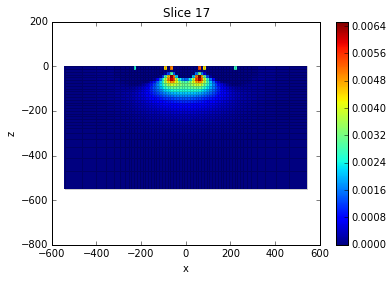

In [27]:
colorbar(mesh.plotSlice(mopt, normal='Y', ind=17, grid=True, gridOpts={'alpha': 0.2, 'color':'black'})[0])
axis('equal')

In [28]:
# sigma_est = expmap * m2to3 * mopt

In [29]:
dpred = surveyIP.dpred(mopt)

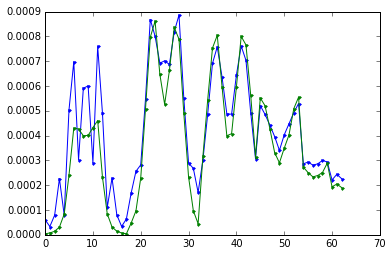

In [30]:
plot(np.c_[dpred,surveyIP.dobs], '.-')